In [ ]:
#@title Imports

# Utils
import time
from tqdm import tqdm

# from csp import *
# Data Structures
import heapq
from collections import deque

# Data Manipulation and computations
import numpy as np
import pandas as pd
import scipy.spatial.distance as dist

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [ ]:
#@title Constraint Evaluation

# -*- coding: utf-8 -*-
"""Copy of Assignment 2 - Constraint Satisfaction Problem.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1egOPdPPd1t-erkJyK7P0x6GF5wDLTJur
"""

import re
import ast
import copy
import numpy as np
import operator as op

# supported operators
operators = {ast.Add: op.add, ast.Sub: op.sub, ast.Mult: op.mul,
             ast.Div: op.truediv, ast.Pow: op.pow, ast.BitXor: op.xor,
             ast.USub: op.neg}

def eval_expr(expr):
    """
    Parameters
    ----------
    expr: str
        String representation of the eqn. to evaluate.
        E.g. '1+2+3'
    
    Returns
    -------
    evaluation_result: Num
        Result of the evaluation

    Usage
    -----
    >>> eval_expr('1 + 2*3**(4^5) / (6 + -7)')
    -5.0
    """
    return eval_(ast.parse(expr, mode='eval').body)

def eval_(node):
    """
    Evaluates an ast node.
    """
    
    if isinstance(node, ast.Num): # <number>
        return node.n
    elif isinstance(node, ast.BinOp): # <left> <operator> <right>
        return operators[type(node.op)](eval_(node.left), eval_(node.right))
    elif isinstance(node, ast.UnaryOp): # <operator> <operand> e.g., -1
        return operators[type(node.op)](eval_(node.operand))
    else:
        raise TypeError(node)



In [ ]:
#@title Constraint Class

class Constraint:

    def __init__(self, string_rep, possible_ops=None):
        """
        Represents a constraint (equation) in the Knowledge Base.

        Parameters
        ----------
        string_rep: str
            String representation of the constraint.
            E.g. "A+B-C=2". All examples in this class use this example
        possible_ops: re.Pattern
            Pattern containing all the possible operators in the constraint.
        """

        self.string_rep = string_rep # Use to access the string representation

        if possible_ops is None:
            self.possible_ops = re.compile("[-+=]")
        else:
            self.possible_ops = possible_ops

        # List of elements. e.g. ['A', 'B', 'C', '2']
        self.elements = self.possible_ops.split(string_rep)

        # Sequence of operators. e.g. ['+', '-', '=']
        self.ops = re.findall(self.possible_ops, self.string_rep)
        
        try:
            # The RHS of the eqn. E.g. 2
            self.result = int(self.elements[-1])
        except ValueError:
            raise ValueError("Constraint has non integer result: " + str(self.elements[-1]))
        except IndexError:
            raise ValueError("Constraint is empty.")
        except Exception:
            self.result = None

        try:
            # Variables in the eqn. E.g. ['A', 'B', 'C']
            self.variables = self.elements[:-1]
        except IndexError:
            raise ValueError(
                "Cannot find variables in Constraint! Constraint =", 
                self.string_rep
            )
        except Exception:
            self.variables = None

    def __repr__(self):
        """ 
        Prints this when an object of this class is returned. 
        """
        return self.string_rep

    def __str__(self):
        """ 
        Prints this when the print() fn. is called on an object of this class.
        """
        return self.string_rep

    def __hash__(self):
        """
        Hash function for constraints.
        """
        return hash(self.string_rep)

    def __eq__(self, other):
        if type(other) != type(self):
            return False

        return self.string_rep == other.string_rep

    def _evaluate_assignment(self, asmt):
        """
        Evaluates the LHS of the eqn. with a particular assignment
        for the variables.

        Parameters
        ----------
        asmt: Dict[str, int]
            Mapping between variables and their values (in the domain).

        Returns
        -------
        lhs: int or None 
            None if assignment cannot be evaluated.
            Integer value of the LHS with this assignment.
        """
        
        # Check how many variables from the eqn. are present in the asmt.
        var_presence = [var in asmt for var in self.variables]

        if not all(var_presence):
            # If all variables are not present
            return None
        elif None in asmt.values():
            # If assignment has None for some value
            return None

        # Substitute values of variables from the assignments in a list
        sub_elements = []
        for i in range(len(self.variables)):
            sub_elements.append(str(asmt[self.variables[i]]))
            if i != len(self.variables) - 1:
                sub_elements.append(self.ops[i])

        # Join to form a string representation
        string_exp = ''.join(sub_elements)

        # Evaluate expression
        return eval_expr(string_exp)

    def is_zero_assignment(self):
        """
        Returns True if RHS = 0.
        """
        return self.result == 0

    def is_ones_assignment(self):
        """
        Returns True if all vars should be assigned the value 1.
        """
        return len(self.variables) == self.result

    def is_satisfied_with_asmt(self, asmt):
        """

        Parameters
        ----------
        asmt: Dict[str, int]
            Mapping between variables and their values (in the domain).

        Returns
        -------
        is_satisfied: 

        Return codes:
            'INCONSISTENT': Some of the variables present in constraint 
                are absent from assignment
            'SATISFIED': Constraint is satisfied with this assignment
            'NOT_SATISFIED': Assignment is valid but does not satisfy constraint
        """
        evaluated_result = self._evaluate_assignment(asmt)

        is_satisfied, exit_status = False, None

        if evaluated_result is None:           # Result could not be evaluated
            is_satisfied = False
            exit_status = "INCONSISTENT"
        elif evaluated_result == self.result:  # LHS == RHS
            is_satisfied = True
            exit_status = "SATISFIED"
        else:                                  # LHS != RHS
            is_satisfied = False
            exit_status = "NOT_SATISFIED"

        return is_satisfied, exit_status

    def is_consistent_with_asmt(self, partial_asmt):
        """
        Checks if with a given (partial) assignment, we can ever get the result
        from the remaining variables.

        Parameters
        ----------
        asmt: Dict[str, int]
            (Partial) assignment of variables.
            E.g. {'A': 0, 'B': 1}

        Returns
        -------
        status: bool
            False if inconsistent assignment else True
        """
        asmt = {k: v for k, v in partial_asmt.items() if v is not None}

        # Change ops to fit the length of the variables
        ops_ = ["+"] + [x for x in self.ops if x != '=']
        
        # No. of vars should equal no. of operations
        assert len(self.variables) == len(ops_)

        # Dictionary mapping each variable to its operation
        var_to_ops = dict(np.array([self.variables, ops_]).T)

        # For collecting the sign counts for limits
        sign_counts = {'+': 0, '-': 0}

        # Collect variables present and absent from assignment
        known_expr = "0"
        for var in self.variables:
            if var not in asmt:
                # Use this to get the limits
                sign_counts[var_to_ops[var]] += 1
            else:
                # Use this for the known evaluation expression
                known_expr += str(var_to_ops[var]) + str(asmt[var])

        # Evaluate result from the variables in the assignment
        known_result = eval_expr(known_expr)

        # Evaluate limits for the possible result
        limits = (known_result - sign_counts['-'], known_result + sign_counts['+'])

        # Return if possible result is inside the limits
        return self.result >= limits[0] and self.result <= limits[1]

In [ ]:
class KnowledgeBase:

    def __init__(self, constraints=None, domain=None):
        
        self.constraints = set([Constraint(x) for x in constraints]) if constraints is not None else set()
        self.domain = (1, 0) if domain is None else domain

        all_vars = [cnst.variables for cnst in self.constraints]
        all_occurences = [item for sublist in all_vars for item in sublist]

        counts = np.unique(all_occurences, return_counts=True)
        self.var_counts = dict(zip(counts[0], counts[1]))
        self.variables = set(self.var_counts.keys())

        self.unit_constraints = set([cnst for cnst in self.constraints if len(cnst.variables) == 1])

    def __repr__(self):
        return str([str(cnst) for cnst in self.constraints])

    def __str__(self):
        return str([str(cnst) for cnst in self.constraints])

    def contains_constraint(self, cnst):
        return cnst in self.constraints

    def is_satisfied_with_asmt(self, asmt):
        if None in asmt.values():
            return False

        return all([cnst.is_satisfied_with_asmt(asmt) for cnst in self.constraints])

    def is_consistent_with_asmt(self, asmt):
        return all([cnst.is_consistent_with_asmt(asmt) for cnst in self.constraints])

    def most_constrained_variable(self, select=None):
        if select is not None:
            select_vars = {k: v for k, v in self.var_counts.items() if k in select}
        else:
            select_vars = self.var_counts.copy()

        return max(select_vars, key=select_vars.get)

    def get_subspace(self, var):
        first_order_cnsts = set([cnst for cnst in self.constraints if (var in cnst.variables)])
        subspace_cnsts = first_order_cnsts.union(self.unit_constraints)

        return [x.string_rep for x in subspace_cnsts]

    def _merge_count_dicts(self, d1, d2):
        """
        Updates dictionary d1 using d2. d1 and d2 store frequencies of elements.

        Parameters
        ----------
        d1: Dict[str, int]
            First dictionary of counts
        d2: Dict[str, int]
            Second dictionary of counts. Should be shorter than the first one.

        Returns
        -------
        d: Dict[str, int]
            Unified dictionary.
        """

        for k, v in d2.items():
            d1[k] = d1.get(k, 0) + v

        return d1

    def add_constraints(self, constraints):
        """
        Adds a new list of constraints to the KB.

        Parameters
        ----------
        constraints: List[str]
            List of string representations of constraints
        """

        # Add new constraints to existing constraints
        new_constraints = set([Constraint(x) for x in constraints])
        new_information = new_constraints - self.constraints
        self.constraints = self.constraints.union(new_constraints)

        # Calculate all occurences of variables in all new constraints
        all_new_vars = [cnst.variables for cnst in new_information]
        new_occurences = [item for sublist in all_new_vars for item in sublist]

        # Add new variables to existing set of variables and update counts
        new_counts = np.unique(new_occurences, return_counts=True)
        new_var_counts = dict(zip(new_counts[0], new_counts[1]))

        self.var_counts = self._merge_count_dicts(self.var_counts, new_var_counts)
        self.variables = self.variables.union(set(new_var_counts.keys()))

        # Update set of unit constraints
        new_unit_constraints = set([cnst for cnst in new_information if len(cnst.variables) == 1])
        self.unit_constraints = self.unit_constraints.union(new_unit_constraints)

In [ ]:
#@title Test Knowledge Base Class

c1 = ["A+B+C=2", "A+C=1", "A+C=1", "E=1"]
kb = KnowledgeBase(c1)

print("Constraints in KB =", kb.constraints)
print("Variable counts in KB =", kb.var_counts)
print("Variables in KB =", kb.variables)
print("Unit constraints in KB =", kb.unit_constraints)
print("")

c2 = ["A+B+C=2", "D=0", "E+F=2"]
kb.add_constraints(c2)

print("Constraints in KB =", kb.constraints)
print("Variable counts in KB =", kb.var_counts)
print("Variables in KB =", kb.variables)
print("Unit constraints in KB =", kb.unit_constraints)
print("")

print(kb._merge_count_dicts({'A': 1, 'B': 1, 'C': 3}, 
                            {'B': 1, 'D': 1}))

Constraints in KB = {A+C=1, E=1, A+B+C=2}
Variable counts in KB = {'A': 2, 'B': 1, 'C': 2, 'E': 1}
Variables in KB = {'E', 'C', 'A', 'B'}
Unit constraints in KB = {E=1}

Constraints in KB = {E+F=2, E=1, A+B+C=2, D=0, A+C=1}
Variable counts in KB = {'A': 2, 'B': 1, 'C': 2, 'E': 2, 'D': 1, 'F': 1}
Variables in KB = {'D', 'F', 'E', 'B', 'C', 'A'}
Unit constraints in KB = {E=1, D=0}

{'A': 1, 'B': 2, 'C': 3, 'D': 1}


In [ ]:
#@title Variable Assignment Tree Node

class VariableAssignmentTreeNode:

    def __init__(self, asmt=None, parent=None, kb=None):
        if asmt is None and kb is None:
            raise ValueError("Both asmt and kb cannot be None together!")

        self.kb = copy.copy(kb)

        self.asmt = asmt.copy() if asmt is not None else self._init_assignment()
        self.parent = parent

    def __repr__(self):
        return str(self.asmt)

    def __str__(self):
        return str(self.asmt)

    def _init_assignment(self):
        base_assignment = {k: None for k in self.kb.variables}

        for cnst in self.kb.unit_constraints:
            var_name, var_value = \
                list(cnst.variables)[0], cnst.result
            
            base_assignment[var_name] = var_value

        return base_assignment

    def update_assignment(self, var, value):
        self.asmt[var] = value

In [ ]:
#@title Backtracking Search

def is_complete(asmt):
    return None not in asmt.values()

def select_unassigned_variable(kb, asmt):
    select = [x for x in asmt.keys() if asmt[x] is None]
    return kb.most_constrained_variable(select=select)

def backtracking_search(root, kb, collect_leaves, 
                        prob_inference= False, limit_leaves=False, 
                        verbose=False):
    
    if limit_leaves and not prob_inference and len(collect_leaves) > 1:
        return

    if is_complete(root.asmt) and kb.is_satisfied_with_asmt(root.asmt):
        collect_leaves.append(root)
        return

    next_var = select_unassigned_variable(kb, root.asmt)

    for value in kb.domain:
        vat_node_next = VariableAssignmentTreeNode(asmt=root.asmt, parent=root)
        vat_node_next.asmt[next_var] = value

        if verbose:
            print("Assignment =", vat_node_next.asmt)
            print("Is KB consistent? =", kb.is_consistent_with_asmt(vat_node_next.asmt))
            print("")

        if kb.is_consistent_with_asmt(vat_node_next.asmt):
            backtracking_search(vat_node_next, kb, collect_leaves, verbose=verbose)

In [ ]:
def merge_dicts_prob(l):
  """
  Merge a list of dictionaries by taking mean of values of variables.
  """

  if not l:
    return {}

  prob_dict = {k: v for k, v in l[0].asmt.items()}

  if len(l) > 1:
    for i in range(1, len(l)):
      prob_dict = {k: v + l[i].asmt.get(k) for k, v in prob_dict.items()}

  return {k: v/len(l) for k, v in prob_dict.items()}

In [ ]:
merge_dicts_prob(collect_leaves)

{'A': 0.3333333333333333, 'B': 0.3333333333333333, 'C': 0.3333333333333333}

In [ ]:
# sample_kb = ['A+B+C=1', 'A+D=1', 'A=1', 'C+B+A=1', 'E=1', 'F=1', 'A=1', 'C=0']
sample_kb = ['A+B+C=1']

kb = KnowledgeBase(constraints=sample_kb)
root = VariableAssignmentTreeNode(kb=kb)

collect_leaves = []

backtracking_search(root, kb, collect_leaves, verbose=True)

collect_leaves

Assignment = {'C': None, 'A': 1, 'B': None}
Is KB consistent? = True

Assignment = {'C': None, 'A': 1, 'B': 1}
Is KB consistent? = False

Assignment = {'C': None, 'A': 1, 'B': 0}
Is KB consistent? = True

Assignment = {'C': 1, 'A': 1, 'B': 0}
Is KB consistent? = False

Assignment = {'C': 0, 'A': 1, 'B': 0}
Is KB consistent? = True

Assignment = {'C': None, 'A': 0, 'B': None}
Is KB consistent? = True

Assignment = {'C': None, 'A': 0, 'B': 1}
Is KB consistent? = True

Assignment = {'C': 1, 'A': 0, 'B': 1}
Is KB consistent? = False

Assignment = {'C': 0, 'A': 0, 'B': 1}
Is KB consistent? = True

Assignment = {'C': None, 'A': 0, 'B': 0}
Is KB consistent? = True

Assignment = {'C': 1, 'A': 0, 'B': 0}
Is KB consistent? = True

Assignment = {'C': 0, 'A': 0, 'B': 0}
Is KB consistent? = False



[{'C': 0, 'A': 1, 'B': 0}, {'C': 0, 'A': 0, 'B': 1}, {'C': 1, 'A': 0, 'B': 0}]

In [ ]:
def infer_for_vars(vars_to_infer, kb, subspace=True, prob_inference=False):
    inferences = []
    for var in vars_to_infer:
        # print("var =", var)

        if var not in kb.variables:
            # print("variable not in kb.\n")
            inferences.append(None)
            continue

        if subspace:
            t0 = time.time()
            # print("Subspacing.")

            var_subspace = kb.get_subspace(var)
            subspace_kb = KnowledgeBase(var_subspace)

            subspace_root = VariableAssignmentTreeNode(kb=subspace_kb)
            collect_leaves = []

            backtracking_search(root=subspace_root, 
                                kb=subspace_kb, 
                                prob_inference=prob_inference, 
                                collect_leaves=collect_leaves)
            
            time_taken = time.time() - t0
            # print("Time taken =", time_taken)

        else:
            t0 = time.time()
            # print("Using full KB.")

            root = VariableAssignmentTreeNode(kb=kb)
            collect_leaves = []

            backtracking_search(root=root, kb=kb, 
                                prob_inference=prob_inference, 
                                collect_leaves=collect_leaves)
            
            time_taken = time.time() - t0
            # print("Time taken =", time_taken)

        var_probs = merge_dicts_prob(collect_leaves)

        # print(var, ":", var_probs, "\n", collect_leaves)

        inferences.append(var_probs)

    return inferences

In [ ]:
L = [{'a': 1, 'b': 2}, {'b': 3, 'a': 1}]

{k: v for d in L for k, v in d.items()}

{'a': 1, 'b': 3}

In [ ]:
constraints = ['c2_17=0', 'c1_8=0', 'c3_22=0', 'c1_7=1', 'c0_10=0', 'c1_19=0', 'c3_24+c3_25+c2_25+c1_25+c1_24+c1_23+c2_23+c3_23=1', 'c2_23=0', 'c1_4=0', 'c1_34=0', 'c2_10+c2_11+c1_11+c0_11+c0_10+c0_9+c1_9+c2_9=1', 'c1_16=0', 'c1_18=1', 'c0_1=0', 'c0_13=0', 'c1_30=0', 'c2_35=0', 'c1_2=0', 'c0_12=0', 'c0_14=0', 'c1_9=0', 'c0_16=0', 'c3_19+c3_20+c2_20+c1_20+c1_19+c1_18+c2_18+c3_18=1', 'c1_12=0', 'c3_33=0', 'c2_15=0', 'c2_30=0', 'c1_17=0', 'c3_28=0', 'c3_37=0', 'c2_17+c2_18+c1_18+c0_18+c0_17+c0_16+c1_16+c2_16=2', 'c2_14=0', 'c2_16=0', 'c1_3=0', 'c2_21=0', 'c1_21=0', 'c2_27=0', 'c1_22=0', 'c3_40=0', 'c3_35+c3_36+c2_36+c1_36+c1_35+c1_34+c2_34+c3_34=2', 'c1_6+c1_7+c0_7+c0_5+c1_5=1', 'c3_31=0', 'c2_32=0', 'c1_0=0', 'c2_39=0', 'c3_30=0', 'c1_33=0', 'c2_25=0', 'c3_26+c3_27+c2_27+c1_27+c1_26+c1_25+c2_25+c3_25=1', 'c0_15=0', 'c1_5=0', 'c0_8=0', 'c3_19=0', 'c3_23=0', 'c3_39=0', 'c1_23=0', 'c1_8+c1_9+c0_9+c0_7+c1_7=2', 'c2_24=0', 'c3_37+c3_38+c2_38+c1_38+c1_37+c1_36+c2_36+c3_36=1', 'c3_32=0', 'c3_34=0', 'c3_18+c3_19+c2_19+c1_19+c1_18+c1_17+c2_17+c3_17=1', 'c2_28=0', 'c1_37=0', 'c1_1=0', 'c1_7+c1_8+c0_8+c0_6+c1_6=1', 'c2_41=0', 'c3_27+c3_28+c2_28+c1_28+c1_27+c1_26+c2_26+c3_26=1', 'c1_29=0', 'c1_40=0', 'c0_5=0', 'c0_9=1', 'c0_3=0', 'c0_6=0', 'c3_29=0', 'c1_31=0', 'c3_21=0', 'c1_41=0', 'c1_39=0', 'c3_41=0', 'c3_25+c3_26+c2_26+c1_26+c1_25+c1_24+c2_24+c3_24=1', 'c2_13=0', 'c0_7=0', 'c2_10=0', 'c3_36+c3_37+c2_37+c1_37+c1_36+c1_35+c2_35+c3_35=2', 'c1_20=0', 'c1_35=1', 'c2_26=0', 'c2_18=0', 'c2_37=0', 'c3_28+c3_29+c2_29+c1_29+c1_28+c1_27+c2_27+c3_27=1', 'c2_42=1', 'c2_9+c2_10+c1_10+c0_10+c0_9+c0_8+c1_8+c2_8=1', 'c0_11=0', 'c2_8+c2_9+c1_9+c0_9+c0_8+c0_7+c1_7+c2_7=2', 'c1_14=0', 'c1_28=0', 'c2_36=0', 'c0_17=1', 'c3_17+c3_18+c2_18+c1_18+c1_17+c1_16+c2_16+c3_16=1', 'c1_32=0', 'c3_38=0', 'c2_34=0', 'c1_10=0', 'c2_19=0', 'c2_11=0', 'c2_12=0', 'c1_38=0', 'c3_20=0']


collect_leaves = []
kb = KnowledgeBase(constraints=constraints)
root = VariableAssignmentTreeNode(kb=kb)

t0 = time.time()

backtracking_search(root, kb, collect_leaves)

time_taken = time.time() - t0

In [ ]:
c1 = Constraint("A+B+C=2")
c2 = Constraint("A+C=1")
c3 = Constraint("A+C=1")

cset = set([c1, c2, c3])

cset2 = set([Constraint("C+D=1"), Constraint("A+C=1")])

print(cset)

cset.add(Constraint("A+B+C=2"))

print(cset)

cset.union(cset2)

{A+C=1, A+B+C=2}
{A+C=1, A+B+C=2}


{A+B+C=2, A+C=1, C+D=1}

In [ ]:
#@title Node Class

class Node:
  
  def __init__(self, parent=None, position=None, recency_factor=None):
    """ 
    Represents a Node in the A* search tree. 
    
    Parameters
    ----------
    parent: Node
      Node for the neighbouring cell from which this node was discovered
    position: (int, int)
      Coordinates of the cell.
    recency_factor: int
      Represents how recently this node was created. Used for breaking ties in
      the priority queue.
    """

    self.parent = parent
    self.position = position
    self.recency_factor = recency_factor

    self.g = 0
    self.h = 0
    self.f = 0
  
  def __eq__(self, other):
    """ 
    For Node comparison. 
    
    Parameters
    ----------
    other: Node
      The object with which this instance needs to be compared.
    """

    # In case 'other' is not a Node
    if type(self) != type(other):
      return False

    return self.position == other.position
  
  def __lt__(self, other):
    """ 
    For heap comparison. 
    
    Parameters
    ----------
    other: Node
      The object with which this instance needs to be compared.
    """

    if self.f < other.f:  # If priority is less
      return True
    elif self.f == other.f:  # If tie, check recency
      if self.recency_factor > other.recency_factor:
        return True
    
    return False


  def __gt__(self, other):
    """
    For heap comparison. 
    
    Parameters
    ----------
    other: Node
      The object with which this instance needs to be compared.
    """

    if self.f > other.f:  # If priority is more
      return True
    elif self.f == other.f:  # If tie, check recency
      if self.recency_factor < other.recency_factor:
        return True
    
    return False

In [ ]:
#@title Neighbourhood Functions

def is_unvisited_and_unblocked(coords, state):
  """
  Checks if a cell is not blocked and not yet visited.
  
  Parameters
  ----------
  coords: (int, int)
    Coordinates of the cell to check
  state: (2D np.array, 2D np.array, 2D np.array)
    The elements are passed in the following order:
      `knowledge` - Represents the knowledge of the agent. knowledge[x][y] = 1 if
        the agent knows there exists a block at position (x, y) and is 0 otherwise.
      `visited` - Represents which nodes the agent has already expanded. visited[x][y] = 1 if
        the agent has already expanded Node at (x, y) and 0 otherwise.
      `in_fringe` - Represents if the node is in the fringe already. in_fringe[x][y] = 1
        if Node at (x, y) is already in the fringe and 0 otherwise.

  Returns
  -------
  True if not blocked and not visited else False
  """

  # Get coordinates
  x, y = coords
  knowledge, visited, _ = state

  # Return false if cell is blocked or already visited
  if knowledge[x][y]['blocked'] or visited[x][y] != 0:
    return False

  return True

def neighbourhood(coords, num_rows, num_cols, nbhd_type="compass", parent_coords=None, sense=False):
  """
  Returns the possible neighbours of a cell. Doesn't check for visited or blocked nodes.
  Assumes the grid is between `(0, 0)` to `(num_rows-1, num_cols-1)`. 

  Parameters
  ----------
  coords: (int, int)
    Coordinates of the cell
  num_rows: int
    No. of rows in the grid.
  num_cols: int
    No. of columns in the grid.
  nbhd_type: str
    `compass` - the agent can see in all 4 directions (up, down, left, right)
    `directional` - the agent can only see in the direction in which it is moving
  parent_coords: (int, int)
    Coordinates of the parent cell, required if `nbhd_type` is `directional`.

  Returns
  -------
  possible_cells: List[(int, int)]
    List of coordinates for the possible neighbours
  """

  if nbhd_type == "compass":

    # Get possible cells
    x, y = coords
    possible_cells = [(x+1, y), (x, y+1), (x-1, y), (x, y-1)]

    if sense:
      possible_cells = [(x + 1, y), (x + 1, y + 1), (x, y + 1), (x - 1, y + 1), (x - 1, y), (x - 1, y - 1), (x, y - 1), (x + 1, y - 1)]
    # Remove cells outside boundaries
    possible_cells = [cell for cell in possible_cells if cell[0] >= 0 and cell[1] >= 0 and cell[0] <= num_rows-1 and cell[1] <= num_cols-1]

    return possible_cells
  
  elif nbhd_type == "directional":

    if parent_coords is None:
      raise ValueError("Parent coords cannot be none if nbhd_type == 'directional'.")

    # Find the possible neighbouring node in the field of view
    cell = tuple(np.array(coords) + (np.array(coords) - np.array(parent_coords)))

    # Check if the node is valid
    possible_cells = [cell] if cell[0] >= 0 and cell[1] >= 0 and cell[0] <= num_rows-1 and cell[1] <= num_cols-1 else []

    return possible_cells
  
  raise ValueError("nbhd type can only be from ['compass', 'directional'], not", nbhd_type)

def get_valid_children(coords, parent, num_rows, num_cols, state):
  """
  Gets valid children for a cell, based on position, known blockages and visited
  neighbours.

  Parameters
  ----------
  coords: (int, int)
    Coordinates of the cell
  parent: Node
    Parent of the cell for which the neighbours need to be created
  num_rows: int
    No. of rows in the grid.
  num_cols: int
    No. of columns in the grid.
  state: (2D np.array, 2D np.array, 2D np.array)
    The elements are passed in the following order:
      `knowledge` - Represents the knowledge of the agent. knowledge[x][y] = 1 if
        the agent knows there exists a block at position (x, y) and is 0 otherwise.
      `visited` - Represents which nodes the agent has already expanded. visited[x][y] = 1 if
        the agent has already expanded Node at (x, y) and 0 otherwise.
      `in_fringe` - Represents if the node is in the fringe already. in_fringe[x][y] = 1
        if Node at (x, y) is already in the fringe and 0 otherwise.

  Returns
  -------
  valid_children: List[(int, int)]
    List of the possible coordinates of the children.
  """

  # Get all possible children
  nbhd = neighbourhood(coords, num_rows, num_cols)

  # Don't add the parent to the list of valid children
  if parent is not None:
    nbhd = [x for x in nbhd if x != parent.position]

  # Remove known blocked and visited cells
  valid_children = [cell for cell in nbhd if is_unvisited_and_unblocked(cell, state)]

  return valid_children

def is_open_cell(cell, knowledge):
    """
    Checks if a cell is open, i.e., has 3 or more unblocked neighbours.

    Parameters
    ----------
    cell: (int, int)
    Coordinates of the cell for which to check
    knowledge: 2D np.array
    Represents the knowledge of the agent. knowledge[x][y] = 1 if
    the agent knows there exists a block at position (x, y) and is 0 otherwise.
    """

    # Get neighbourhood of the cell
    nbhd = neighbourhood(cell, knowledge.shape[0], knowledge.shape[1])

    # Retain only the unblocked ones
    unblocked = [nbr for nbr in nbhd if knowledge[nbr[0]][nbr[1]] != 1]

    # Check length of unblocked cells
    if len(unblocked) >= 3:
        return True

    return False

In [ ]:
#@title Generate Gridworld

def generate_gridworld(shape, block_prob):
  """
  Parameters
  ----------
  shape: (int, int)
    Number of rows and columns in the required gridworld
  block_prob: float
    Each cell is blocked with a probability p = block_prob

  Returns
  -------
  grid_world: 2D np.array
    Grid with each cell blocked with a probability `block_prob`.
  """

  num_rows, num_cols = shape

  # Randomly sample a 2D array with each cell being either 1 or 0 with prob as block_prob
  grid_world = np.random.choice([1, 0], (num_rows, num_cols), p=[block_prob, 1-block_prob])

  # Exclude start and end cells
  grid_world[0][0] = 0
  grid_world[num_rows-1][num_cols-1] = 0

  return grid_world

In [ ]:
#@title A* Search

def grid_path(current_node):
    """ 
    Recursively finds the path from the leaf to the root node in the A* search tree. 
    
    Parameters
    ----------
    current_node: Node
      Node in the A* search tree.

    Returns
    -------
    planned_path: List[(int, int)]
      Path from the root node to this leaf node
    """

    path = []

    # Recursively travel up to the root
    current = current_node

    while current != None:
      path.append(current.position)
      current = current.parent

    # Reverse and return
    return path[::-1]
  
def heuristic(name, start, end):
    """ 
    Returns the heuristic (distance) between the start and end cells. 

    Parameters
    ----------
    name: str
      Can be `'euclidean'`, `'manhattan'`, or `'chebyshev'`.
    start: (int, int)
      Coordinates of the start cell
    end: (int, int)
      Coordinates of the end cell

    Returns
    -------
    distance: float or int
      Distance based on which heuristic is being used.
    """

    if name == "euclidean":
      return dist.euclidean(start, end)
    elif name == "manhattan":
      return dist.cityblock(start, end)
    elif name == "chebyshev":
      return dist.chebyshev(start, end)

    # If heuristic is unknown, raise error
    raise NotImplementedError("Unknown heuristic:", name)


def a_star_search(start, goal, grid, heuristic_type, 
                  visited, knowledge, max_steps=None, 
                  epsilon=1.):
  """ 
  Executes A* search on a grid.

  Parameters
  ----------
  start: (int, int)
    Coordinates of the start cell.
  goal: (int, int)
    Coordinates of the goal cell.
  grid: 2D np.array
    Represents the original grid on which A* needs to be executed
  heuristic_type: str
    Type of heuristic to use. Can be `'euclidean'`, `'manhattan'`, or `'chebyshev'`
  visited: 2D np.array
    Represents which nodes the agent has already expanded. visited[x][y] = 1 if
    the agent has already expanded Node at (x, y) and 0 otherwise.
  knowledge: 2D np.array
    Represents the knowledge of the agent. knowledge[x][y] = 1 if
    the agent knows there exists a block at position (x, y) and is 0 otherwise.
  max_steps: int or None
    Max. number of times we pop a Node from the Fringe
  epsilon: float
    Weight given to the heuristic function while calculating the priority f. Used as:
    f(n) = g(n) + epsilon*h(n)

  Returns
  -------
  planned_path: List[(int, int)]
    List of cells to traverse from the start node to end node
  exit_status: str
    `"SUCCESS"` - If A* was successfully completed
    `"FAILED_NOPATH"` - If no path can be found from the start to the goal cells
    `"FAILED_STEPS"` - Max. number of steps was reached and path not found
  num_cells_propped: int
    Total number of nodes popped from the fringe throughout the search process.
  
  TODO
  ----
  - num_cells_popped == steps? Remove num_cells_popped and use steps instead
  - Remove the `grid` parameter since this is not required
  - Implement a separate `Fringe` class
  """
  start_node = Node(position=start)
  goal_node = Node(position=goal)

  # Implementing priority queue using heap
  fringe = []
  in_fringe = np.zeros(grid.shape)
  heapq.heapify(fringe)

  # Initialize tracking parameters
  recency_counter = 0
  num_cells_popped = 0

  # Add start node to the fringe
  start_node.recency_factor = recency_counter
  heapq.heappush(fringe, start_node)
  in_fringe[start[0]][start[1]] = 1
  recency_counter += 1
  
  # Stopping condition
  if max_steps is None:
    max_steps = grid.shape[0] * grid.shape[1]

  steps = 0
  exit_status = "FAILED_NOPATH"

  # Start
  while fringe:
    
    steps += 1

    # Pop the current node from the fringe
    current_node = heapq.heappop(fringe)
    num_cells_popped += 1
    curr_x, curr_y = current_node.position

    # Visit the current node and note that it is out of the fringe
    visited[curr_x][curr_y] = 1
    in_fringe[curr_x][curr_y] = 0

    # Check and return path if we have reached the goal node
    if current_node == goal_node:
      exit_status = "SUCCESS"
      return grid_path(current_node), exit_status, num_cells_popped

    # Stopping condition
    if steps > max_steps:
      exit_status = "FAILED_STEPS"
      return grid_path(current_node), exit_status, num_cells_popped

    # Create children
    children = get_valid_children(current_node.position, current_node.parent, grid.shape[0], grid.shape[1], (knowledge, visited, in_fringe))
    children = [Node(current_node, x) for x in children]

    # Set parameters for each child
    for i in range(len(children)):
      children[i].g = current_node.g + 1
      children[i].h = heuristic(heuristic_type, children[i].position, goal)
      children[i].f = children[i].g + epsilon*children[i].h
      children[i].recency_factor = recency_counter

      heapq.heappush(fringe, children[i])
      in_fringe[children[i].position[0]][children[i].position[1]] = 1

      recency_counter += 1

  return [], exit_status, num_cells_popped

In [ ]:
#@title Grid Visualization

def visualize_grid(sol, grid):
  """
  Visualize grid with the solution on top of it, marked by `*`.

  Parameters
  ----------
  sol: List[(int, int)]
    List of cells in the path from the start to end node
  grid: 2D np.array
    Grid on which to superimpose the solution

  Returns
  -------
  vis_grid: 2D np.array
    The grid to visualize. Use with `pretty_print`.
  """

  # Create copy of the original grid
  vis_grid = grid.copy().astype(str)

  # Mark path on grid
  for cell in sol:
    vis_grid[cell[0]][cell[1]] = "*"

  return vis_grid

def pretty_print(A):
  """
  Prints a 2D np.array with good visual clarity
  
  Parameters
  ----------
  A: 2D np.array
    The grid to visualize
  """
  print('\n'.join([''.join(['{:4}'.format(item) for item in row]) for row in A]))

In [ ]:
#@title Test A* Search Custom

def test_a_star_search_custom(grid=None):
    if grid is None:
        grid = [[0, 1, 0, 1, 0, 0, 1, 0, 0, 0],
                [0, 1, 0, 1, 1, 0, 1, 0, 0, 0],
                [0, 1, 1, 1, 0, 0, 0, 0, 1, 0],
                [0, 1, 0, 0, 0, 1, 0, 1, 1, 0],
                [0, 1, 0, 1, 1, 0, 1, 1, 0, 0],
                [0, 1, 0, 1, 0, 0, 1, 0, 0, 1],
                [0, 1, 0, 1, 0, 0, 0, 0, 0, 0],
                [0, 1, 0, 1, 1, 0, 1, 0, 0, 1],
                [0, 0, 0, 1, 1, 0, 1, 0, 0, 0],
                [1, 1, 0, 1, 0, 0, 0, 0, 1, 0]]

    grid = np.array(grid)

    visited = np.zeros(grid.shape)
    blocked = grid.copy()

    sol = a_star_search((0, 0), (grid.shape[0]-1, grid.shape[1]-1), grid, "euclidean", visited, blocked)

    pretty_print(grid)
    print("\n")
    pretty_print(visualize_grid(sol, grid))

In [ ]:
def custom_inference_engine(cell, knowledge, path_tail, variables_grid, kb, infered_cells, lower_cutoff=0., upper_cutoff=1.):
    """
    Agent infers based on the collect data according to the defined rules (given ahead)
    Updates the knowledge base
    Returns a boolean about if the next step can be taken

    Parameters
    ----------
    cell: (int, int)
        Coordinates of the cell for which to check
    knowledge: 2D array
        Represents the original environment
    path_tail: 1D np.array
        Represents the remaining planned path to goal from `cell` 
        
    Returns
    -------
    move_ahead: bool
        True if we can go ahead in the path, False if the path ahead is blocked
    num_of_inferred_cells: int
        Number of cells for which inference was possible
    """

    for i in path_tail:
        if knowledge[i[0]][i[1]]['blocked']:
            return False, 0

    nbhd = neighbourhood(cell, len(knowledge), len(knowledge), sense=True)
    cells_to_infer = set(nbhd + path_tail) - infered_cells
    cells_to_infer = [variables_grid[i[0]][i[1]] for i in cells_to_infer]

    inference_for_cells = infer_for_vars(cells_to_infer, kb, subspace=True, prob_inference=False)

    constraints = []
    num_of_cells_inferred = 0

    for i, j in zip(cells_to_infer, inference_for_cells):
        if j:
            cell_from_var = tuple([int(k) for k in i.split('c')[1].split('_')])

            # print("Inference for cell =", j)

            new_constraints = []
            for k, v in j.items():
                if v <= lower_cutoff:
                    var_value = 0
                elif v >= upper_cutoff:
                    var_value = 1
                else:
                    var_value = None
                
                if var_value is not None:
                    new_constraint = f'{k}={var_value}'
                    new_constraints.append(new_constraint)

            # print("constraint =", new_constraints)

            constraints += new_constraints

            infered_cells = infered_cells.union(set(list(j.keys())))
            num_of_cells_inferred += len(new_constraints)

            new_states = {k: dict(blocked=(v==1), state=v) for k, v in j.items()}

            # print("new_states =", new_states)
            
            for k, new_state in new_states.items():
                update_knowledge_base(knowledge, tuple([int(a) for a in k.split('c')[1].split('_')]), new_state)

    kb.add_constraints(constraints)

    return True, num_of_cells_inferred

In [ ]:
#@title Update Knowledge

from collections import deque

def update_knowledge_base(knowledge, cell, new_state):
  """
    Updates the knowledge of the cell based on the inferences/observations made  
    Returns the new updated knowledge base
    
    Parameters
    ----------
     knowledge: 2D array
        Represents the observed environment
    cell: (int, int)
        Coordinates of the cell for which to check
    new: dictionary
        Represents the changed states
    
    Returns
    -------
    knowledge: 2D array
        Updated knowledge base with new information about the cell gained by inference/observation
    """
  x, y = cell

  for k, v in new_state.items():
    knowledge[x][y][k] = v

  # re-adjusting hidden cells
  if not knowledge[x][y]['blocked']:
    knowledge[x][y]['h_x'] = knowledge[x][y]['n_x'] - knowledge[x][y]['b_x'] - knowledge[x][y]['e_x']

In [ ]:
def sense_and_update(cell, grid, knowledge, variables_grid, kb, infered_cells):
    """
    Senses around a cell 
    Gets the count of the number of cells and count of the sensed blocked cells around it
    Updates the knowledge with this information

    Parameters
    ----------
    cell: (int, int)
        Coordinates of the cell for which to check
    grid: 2D np.array
        Represents the original environment
    grid: 2D np.array
        Represents the original environment
        
    Returns
    -------
    knowledge: 2D array
        Updated knowledge base with new information collected by the agent using its partial visibility characteristic.
    infer: Boolean
        Did we get any information to even run the inference
    """
    
    x, y = cell

    if (knowledge[x][y]['h_x'] == 0) or (knowledge[x][y]['visited']) or (knowledge[x][y]['state'] != -1):
      return False
    # print('sensing', cell)
    
    # Get possible cells - east, south-east, south, south-west, west, north-west, north, north-east - all 8 directions
    possible_cells = [(x + 1, y), (x + 1, y + 1), (x, y + 1), (x - 1, y + 1), (x - 1, y), (x - 1, y - 1), (x, y - 1), (x + 1, y - 1)]
    
    num_rows, num_cols = grid.shape

    # Get count of neighbouring cells and blocked cells 
    nbhd_count = 0 
    sensed_blocked_count = 0
    empty_confirmed_count = 0
    blocked_confirmed_count = 0
    hidden_count = 0

    for p_cell in possible_cells:
        if (0 <= p_cell[0] <= num_rows - 1) and (0 <= p_cell[1] <= num_cols - 1):
            nbhd_count += 1
            if knowledge[p_cell[0]][p_cell[1]]['state'] == 0:
              empty_confirmed_count += 1
            if knowledge[p_cell[0]][p_cell[1]]['state'] == 1:
              blocked_confirmed_count += 1
            if grid[p_cell[0]][p_cell[1]] == 1:
              sensed_blocked_count += 1
    
    nbhd = neighbourhood(cell, grid.shape[0], grid.shape[1], sense=True)

    # Cx = Bx
    if empty_confirmed_count == sensed_blocked_count:
        constraints = []
        for i in nbhd:
            constraints.append(f'{variables_grid[i[0]][i[1]]}=0')
            infered_cells.add(f'{variables_grid[cell[0]][cell[1]]}')  
            new_state = dict(blocked=False, state=0)
            update_knowledge_base(knowledge, i, new_state)
          
        kb.add_constraints(constraints)

    # Nx - Cx = Ex
    if (nbhd_count - sensed_blocked_count) == empty_confirmed_count:

        constraints = []
        for i in nbhd:
            constraints.append(f'{variables_grid[i[0]][i[1]]}=1')
            infered_cells.add(f'{variables_grid[cell[0]][cell[1]]}')
            new_state = dict(blocked=True, state=1)  
            update_knowledge_base(knowledge, i, new_state)

        kb.add_constraints(constraints)
    
    # All cells around are unblocked
    if sensed_blocked_count == 0:
        constraints = []

        for i in nbhd:
          constraints.append(f'{variables_grid[i[0]][i[1]]}=0')
          infered_cells.add(f'{variables_grid[cell[0]][cell[1]]}')  
          new_state = dict(blocked=False, state=0)
          update_knowledge_base(knowledge, i, new_state)

        kb.add_constraints(constraints)   

    # All cells around are blocked
    elif len(nbhd) == sensed_blocked_count:

      constraints = []

      for i in nbhd:
        constraints.append(f'{variables_grid[i[0]][i[1]]}=1')
        infered_cells.add(f'{variables_grid[cell[0]][cell[1]]}')
        new_state = dict(blocked=True, state=1)  
        update_knowledge_base(knowledge, i, new_state)

      kb.add_constraints(constraints)

    else:
      valid_nbhd = [variables_grid[i[0]][i[1]] for i in nbhd]

      constraint = "+".join(valid_nbhd)
      constraint += f'={sensed_blocked_count}'

      infered_cells.add(f'{variables_grid[cell[0]][cell[1]]}')  
      kb.add_constraints([f'{variables_grid[cell[0]][cell[1]]}=0',constraint])

      # Updating the knowledge base with the discovered information
      new_state = dict(n_x=nbhd_count, 
                       c_x=sensed_blocked_count, 
                       e_x=empty_confirmed_count, 
                       b_x=blocked_confirmed_count, 
                       visited=True, 
                       blocked=False, 
                       state=0)
      
      update_knowledge_base(knowledge, cell, new_state)
      
    return True

In [ ]:
# def print_inferred_cells(knowledge):
#   for i in range(len(knowledge)):
#     for j in range(len(knowledge)):
#       if knowledge[i][j]['state'] == 1:
#         print('inferred/sensed blocked at', i, j)
#       if knowledge[i][j]['state'] == 0:
#         print('inferred/sensed empty at', i, j)

class MoverAndRecorder:

  def __init__(self):
    self.total_time = 0
    self.sensing_times = []
    self.inference_times = []
    self.num_of_inferred_cells = 0
    self.bumped = False
    self.last_open_cell = None
    self.steps = 0
    self.move_ahead = True

  def logs(self):
    return {
      "total_time": self.total_time,
      "sensing_times": self.sensing_times,
      "inference_times": self.inference_times,
      "num_of_inferred_cells": self.num_of_inferred_cells,
      "bumped": self.bumped,
      "last_open_cell": self.last_open_cell,
      "steps": self.steps,
      "move_ahead": self.move_ahead
    }

  def move_and_record(self, start, goal, grid, 
                      planned_path, knowledge, 
                      variables_grid, kb, infered_cells,
                      lower_cutoff=0., upper_cutoff=1., 
                      nbhd_type="compass"):
      """
      Moves the robot along the path and records the environment as it travels.
      If a block is encountered, returns the last unblocked location.

      Parameters
      ----------
      start: (int, int)
        The start coordinates in the grid. Between (0, 0) and
        (grid.shape[0]-1, grid.shape[1]-1).
      goal: (int, int)
        The goal coordinates in the grid. Limits are similar to start.
      planned_path: List[(int, int)]
        List of coordinates (including start and end) to visit.
      knowledge: 2D np.array
        Represents the knowledge of the agent. knowledge[x][y] = 1 if
        the agent knows there exists a block at position (x, y) and is 0 otherwise.
      nbhd_type: str
        `'compass'` if the agent can see in all 4 directions while moving and
        `'directional'` if the agent can see only in the direction it is moving in

      Returns
      -------
      final_node: (int, int)
        The last unblocked node visited or the goal node.
      knowledge: 2D np.array
        Updated knowledge array.
      steps: int
        Number of steps taken along the path.
      last_open_cell: (int, int)
        The last cell seen with no. of unblocked neighbours >= 3
      """

      total_time_start = time.time()

      if not planned_path:  # Planned path is empty
          raise ValueError("Planned path cannot be empty.")

      if planned_path[0] != start:  # Planned path and start don't coincide
          raise ValueError("Planned path doesn't start with 'start'! planned_path[0] =",
                          planned_path[0], "start =", start)

      # Start moving
      for i in range(len(planned_path)):
          cell = planned_path[i]

          # If cell is blocked, return the last known location
          if grid[cell[0]][cell[1]] == 1:

            self.bumped = True

            # Add the constraints to KB that this cell is blocked.
            kb.add_constraints([f'{variables_grid[cell[0]][cell[1]]}=1'])
            infered_cells.add(f'{variables_grid[cell[0]][cell[1]]}')

            # Update knowledge
            new_state = dict(visited=False, blocked=True, state=1)
            update_knowledge_base(knowledge, cell, new_state)

            total_time = time.time() - total_time_start
            self.total_time = total_time

            # Return the last unblocked cell in the planned path
            return planned_path[i - 1]

          t_sense_start = time.time()

          # Collect data and update knowledge for each cell
          infer = sense_and_update(cell, grid, knowledge, variables_grid, kb, infered_cells)   
          
          sensing_time = time.time() - t_sense_start
          self.sensing_times.append(sensing_time)

          # Calling the inference engine to get updated knowledge and whether to move into replanning or continue with move_and_record. 
          if infer:
            t_infer_start = time.time()

            self.move_ahead, num_of_cells_inferred = \
              custom_inference_engine(cell, 
                                      knowledge, 
                                      planned_path[i+1:i+5], 
                                      variables_grid, 
                                      kb, 
                                      infered_cells,
                                      upper_cutoff=upper_cutoff,
                                      lower_cutoff=lower_cutoff)

            infer_time = time.time() - t_infer_start

            self.inference_times.append(infer_time)
            self.num_of_inferred_cells += num_of_cells_inferred
          else:
            self.inference_times.append(0)

          # for the trajectory measure
          self.steps += 1
          
          if self.move_ahead:
            continue
          else:
            total_time = time.time() - total_time_start
            self.total_time = total_time

            return planned_path[i]

      total_time = time.time() - total_time_start
      self.total_time = total_time

      return planned_path[i]

In [ ]:
class RepeatedAStar:

  def __init__(self, grid, lower_cutoff=0., upper_cutoff=1., move_nbhd_type="compass", epsilon=1., 
               escape_tunnels=False):
    """ 
    Implements the Repeated A* algorithm on a grid-world. 
    
    Parameters
    ----------
    grid: 2D np.array
      The grid world on which we need to implement the algorithm
    move_nbhd_type: str
      Can be 'compass' (see in all 4 directions in the execution phase) 
      or 'directional' (see in only the direction of the movement 
      in the execution phase)
    epsilon: float
      Weight with which the heuristic function is multiplied, as:
      f(n) = g(n) + epsilon*h(n)
    escape_tunnels: bool
      Set to true to restart A* from the start of a tunnel by backtracking
      instead of dead-ends
    """

    # Logging
    self.knowledge_snaps = []
    self.visited_snaps = []
    self.start_end_snaps = []
    self.sol_snaps = []
    self.step = 0
    self.successfully_completed = False
    self.final_exit_status = None
    self.grid = grid
    self.total_cells_processed_by_run = []
    self.backtracks = []
    self.bumps = 0
    self.kb_snaps = []
    self.move_and_record_times = []
    self.planning_times = []
    self.total_times = []
    self.move_and_record_logs = []

    # Algorithm parameters
    self.epsilon = epsilon
    self.move_nbhd_type = move_nbhd_type
    self.escape_tunnels = escape_tunnels
    self.upper_cutoff = upper_cutoff
    self.lower_cutoff = lower_cutoff

  def _update_state(self, knowledge, visited, path_end_points, soln, 
                    step, successfully_completed, final_exit_status, 
                    num_cells_popped):
    """ 
    Updates the state (logging variables) after each run of the planning + execution phases. 
    
    Parameters
    ----------
    knowledge: 2D np.array
      Represents the knowledge of the agent. knowledge[x][y] = 1 if
      the agent knows there exists a block at position (x, y) and is 0 otherwise.
    visited: 2D np.array
      Represents which nodes the agent has already expanded. visited[x][y] = 1 if
      the agent has already expanded Node at (x, y) and 0 otherwise.
    path_end_points: ((int, int), (int, int))
      Start and end points for 1 run of A* search
    soln: List[(int, int)]
      Planned path from the start node to the end node for 1 run of A* search
    step: int
      The step number for repeated A* search
    successfully_completed: bool
      If goal node has been reached by repeated A* search
    final_exit_status: str
      `"SUCCESS"` - If A* was successfully completed
      `"RUNNING"` - If Repeated A* search is still running
      `"FAILED_NOPATH"` - A* search could not find a path between the start and end nodes
      `"FAILED_STEPS"` - No. of steps in 1 run of A* search exceeded max steps
      `"FAILED_STEPS_REP"` - No. of steps for repeated A* search exceeded max steps
    num_cells_popped: int
      Number of cells popped during one run of A* search

    TODO
    ----
    - Add backtracks to the final path
    """
    
    self.knowledge_snaps.append(knowledge)
    self.visited_snaps.append(visited)
    self.start_end_snaps.append(path_end_points)
    self.sol_snaps.append(soln)
    self.step = step
    self.successfully_completed = successfully_completed
    self.final_exit_status = final_exit_status
    self.total_cells_processed_by_run.append(num_cells_popped)

  def logs(self):
    """
    Fetches all the logging parameters

    Returns
    -------
    log: Dict[str, Any]
      All logging vars added to a dictionary
    """
    return {
        "grid": self.grid,
        "knowledge": self.knowledge_snaps,
        "visited": self.visited_snaps,
        "start_end": self.start_end_snaps,
        "solns": self.sol_snaps,
        "num_steps": self.step,
        "successfully_completed": self.successfully_completed,
        "final_exit_status": self.final_exit_status
    }

  def path_followed(self):
    """ Returns the actual path followed (planning + execution) """

    # If the paths followed and solutions don't match
    assert len(self.sol_snaps) == len(self.start_end_snaps), \
      "More steps for A* than elements in start_end."
    
    full_path = []
    for i in range(len(self.start_end_snaps)):

      # Get index of end node in path
      _, end_node = self.start_end_snaps[i]
      end_index = self.sol_snaps[i].index(end_node)

      # Clip the array according to end index and append to parent array
      clipped_array = self.sol_snaps[i][:end_index]
      full_path += clipped_array

    return full_path

  def total_cells_processed(self):
    """
    Returns total number of Nodes popped from the Fringe across each run of A* search.
    """
    
    return sum(self.total_cells_processed_by_run)

  def total_backtracked_cells(self):
    """ 
    Returns total number of cells backtracked to the start of a tunnel.
    """

    flat_list = [item for sublist in self.backtracks for item in sublist]
    return len(flat_list)

  def search(self, start, goal, grid, heuristic_type, 
             max_steps_astar=None, max_steps_repeated=None):
    """
    Performs the repeated search on a grid.

    Parameters
    ----------
    start: (int, int)
      Coordinates of the start node
    goal: (int, int)
      Coordinates of the goal node
    grid: 2D np.array
      Original gridworld on which to perform grid search
    heuristic_type: str
      Can be `'euclidean'`, `'manhattan'`, or `'chebyshev'`
    max_steps_astar: int
      Max. no. of steps for 1 run of A* search
    max_steps_repeated: int
      Max. no. of steps for 1 run of Repeated A* search
    """

    # Exit condition
    if max_steps_repeated is None:
      max_steps_repeated = grid.shape[0]*grid.shape[1]

    # Initialize visited matrix, knowledge matrix and planned_path array    
    knowledge = []
    for i in range(grid.shape[0]):
      row = []
      for j in range(grid.shape[1]):
        row.append(dict(n_x=0, blocked=False, visited=False, state=-1, c_x=0, b_x=0, e_x=0, h_x=-1))
      knowledge.append(row)


    #set up variable names for inference
    variables_grid = []
    for i in range(grid.shape[0]):
      row = []
      for j in range(grid.shape[1]):
        row.append(f'c{i}_{j}')
      variables_grid.append(row)
    

    # Initialize Knowledge Base for constraints
    kb =  KnowledgeBase()

    bumped = 0

    #initialize list to hold infered cells
    infered_cells = set()

    # Start
    while not self.successfully_completed:

      time_total_start = time.time()

      # If number of steps have been exceeded for Repeated A*
      if self.step > max_steps_repeated:
        self._update_state(None, None, (None, None),
                           None, self.step, False,
                           "FAILED_STEPS_REP", 0)
        return

      visited = np.zeros(grid.shape)

      time_plan_start = time.time()

      # Run A* search algorithm once
      planned_path, exit_status, num_cells_popped = \
        a_star_search(start, goal, grid, heuristic_type, 
                      visited, knowledge, max_steps=max_steps_astar, 
                      epsilon=self.epsilon)
        
      time_plan = time.time() - time_plan_start
    
      self.planning_times.append(time_plan)

      try:
        print(planned_path[0])
      except IndexError:
        return

      # If no path can be found
      if exit_status == "FAILED_NOPATH":
        self._update_state(knowledge, visited, (start, None), 
                           planned_path, self.step + 1, False, 
                           exit_status, num_cells_popped)
        return

      # If num of steps were exceeded for one run of A*
      elif exit_status == "FAILED_STEPS":
        self._update_state(knowledge, visited, (start, None), 
                           planned_path, self.step + 1, False, 
                           exit_status, num_cells_popped)
        return

      # Move robot along the grid on the planned path and record environment

      time_mv_rc_start = time.time()
    
      mvr = MoverAndRecorder()

      final_node = mvr.move_and_record(start, goal, grid, 
                                      planned_path, knowledge,
                                      variables_grid, kb, infered_cells,
                                      upper_cutoff=self.upper_cutoff, lower_cutoff=self.lower_cutoff,
                                      nbhd_type=self.move_nbhd_type)
      
      time_mv_and_record = time.time() - time_mv_rc_start

      if mvr.bumped:
        self.bumps += 1

      last_open_cell = mvr.last_open_cell
      self.move_and_record_times.append(time_mv_and_record)
      self.move_and_record_logs.append(mvr.logs())

      self.kb_snaps.append(copy.copy(kb))

      # If we were able to reach the goal successfully
      if final_node == goal:
        self._update_state(knowledge, visited, (start, final_node), 
                           planned_path, self.step + 1, True, 
                           "SUCCESS", num_cells_popped)
        continue

      # If we were not able to reach the goal successfully, repeat until possible
      self._update_state(knowledge, visited, (start, final_node), 
                         planned_path, self.step + 1, False,
                         "RUNNING", num_cells_popped)
      
      # Backtracking to the start of tunnels if this parameter is set, else start from end of last path
      if self.escape_tunnels and last_open_cell is not None and final_node != last_open_cell:
        start = last_open_cell

        loc_idx = planned_path.index(last_open_cell)
        backtrack = reversed(planned_path[loc_idx:])

        self.backtracks.append(backtrack)
      else:
        start = final_node

      time_total = time.time() - time_total_start

      self.total_times.append(time_total)

    # We were able to reach successfully
    return

In [ ]:
#@title Test Repeated A* Search

def test_repeated_a_star_search_custom(grid=None, move_nbhd_type="compass", epsilon=1., escape_tunnels=False):
    """ 
    For custom testing of the repeated A* search algorithm. The default grid presents
    a particularly difficult case for A* search. 

    Parameters
    ----------
    move_nbhd_type: str
    `'compass'` - Agent can see in all 4 directions while moving
    `'directional'` - Agent can only see in the direction it is moving
    epsilon: float
    Weight given to the heuristic function. Used as:
    f(n) = g(n) * epsilon*h(n)
    escape_tunnels: bool
    Escape tunnels before restarting A* search
    """
    # grid = [[0, 1, 0, 1, 0, 0, 1, 0, 0, 0],
    #         [0, 1, 0, 1, 1, 0, 1, 0, 0, 0],
    #         [0, 1, 1, 1, 0, 0, 0, 0, 1, 0],
    #         [0, 1, 0, 0, 0, 1, 0, 1, 1, 0],
    #         [0, 1, 0, 1, 1, 0, 1, 1, 0, 0],
    #         [0, 1, 0, 1, 0, 0, 1, 0, 0, 1],
    #         [0, 1, 0, 1, 0, 0, 0, 0, 0, 0],
    #         [0, 1, 0, 1, 1, 0, 1, 0, 0, 1],
    #         [0, 0, 0, 1, 1, 0, 1, 0, 0, 0],
    #         [1, 1, 0, 1, 0, 0, 0, 0, 1, 0]]

    # grid = [[0, 0, 0, 0],
    #         [0, 1, 1, 1],
    #         [0, 0, 1, 0],
    #         [1, 0, 0, 0]]

    if grid is None:
        grid = [[0, 0, 0, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 1, 1, 0, 0, 0, 0],
                [0, 1, 0, 1, 1, 0, 0, 1],
                [0, 0, 0, 0, 0, 1, 0, 1],
                [1, 0, 0, 1, 1, 0, 1, 0],
                [0, 0, 1, 0, 0, 0, 1, 0],
                [0, 0, 0, 0, 1, 0, 0, 0]]

        grid = np.array(grid)

    # Run Repeated A* on the grid
    repeated_a_star = RepeatedAStar(grid, move_nbhd_type=move_nbhd_type, epsilon=epsilon, escape_tunnels=escape_tunnels)
    repeated_a_star.search((0, 0), (grid.shape[0]-1, grid.shape[1]-1), grid, "manhattan")

    # Return the completed R.A* object
    return repeated_a_star

def test_repeated_a_star_search_random(grid_shape,
                                       block_prob, 
                                       heuristic_type="euclidean", 
                                       move_nbhd_type="compass", 
                                       solvable=True, 
                                       epsilon=1., 
                                       escape_tunnels=False,
                                       max_steps_astar=None,
                                       max_steps_repeated=None,
                                       upper_cutoff=1.,
                                       lower_cutoff=0.):
  """ 
  For random testing of the repeated A* search algorithm. 
  
  Parameters
  ----------
  grid_shape: (int, int)
    Shape of the randomly generated gridworld
  block_prob: float
    Each cell in the randomly generated gridworld will be blocked with p = block_prob
  heuristic_type: str
    Can be `'euclidean'`, `'manhattan'`, or `'chebyshev'`
  move_nbhd_type: str
    `'compass'` - Agent can see in all 4 directions while moving
    `'directional'` - Agent can only see in the direction it is moving
  solvable: bool
    Set to True if the randomly generated gridworld has to be solvable 
  epsilon: float
    Weight given to the heuristic function. Used as:
    f(n) = g(n) * epsilon*h(n)
  escape_tunnels: bool
    Escape tunnels before restarting A* search
  """

  grid = None

  # If the grid needs to be solvable
  if solvable:
    is_solvable = False

    # Keep generating random gridworlds until a solvable one comes up
    while not is_solvable:

      # Generate and check solvability of gridworld
      

      grid = generate_gridworld(grid_shape, block_prob=block_prob)
      knowledge = []
      for i in range(grid.shape[0]):
        row = []
        for j in range(grid.shape[1]):
          if grid[i][j] == 1:
            row.append(dict(n_x=0, blocked=True, visited=False, state=-1, c_x=0, b_x=0, e_x=0, h_x=0))
          else:
            row.append(dict(n_x=0, blocked=False, visited=False, state=-1, c_x=0, b_x=0, e_x=0, h_x=0))
        knowledge.append(row)
  
      _, exit_status, _ = a_star_search((0, 0), 
                                        (grid.shape[0]-1, grid.shape[1]-1), 
                                        grid, 
                                        heuristic_type, 
                                        np.zeros(grid.shape), 
                                        knowledge)

      # If gridworld is solvable, break out of loop
      if exit_status == "SUCCESS":
        is_solvable = True
  else:
    # Else generate a random gridworld
    grid = generate_gridworld(grid_shape, block_prob=block_prob)

  t0 = time.time()

  # Run Repeated A* on the grid
  repeated_a_star = RepeatedAStar(grid, 
                                  move_nbhd_type=move_nbhd_type, 
                                  epsilon=epsilon, 
                                  escape_tunnels=escape_tunnels)
  repeated_a_star.search((0, 0), (grid.shape[0]-1, grid.shape[1]-1), grid, heuristic_type,
                         max_steps_repeated=max_steps_repeated, max_steps_astar=max_steps_astar)

  time_taken = time.time() - t0

  # Return the completed R.A* object and the time taken
  return repeated_a_star, time_taken

In [ ]:
NUM_ITERS = 1
DIM_ROWS, DIM_COLS, P = 50, 50, 0.20
HEURISTIC_FN = "manhattan"

ras, time_taken = test_repeated_a_star_search_random((DIM_ROWS, DIM_COLS), P, HEURISTIC_FN)

print("\nTime taken =", time_taken)

(0, 0)
(0, 4)
(1, 8)
(2, 24)
(3, 33)
(4, 36)
(4, 36)
(6, 35)
(7, 39)
(8, 40)
(8, 40)
(10, 41)
(10, 41)
(10, 40)
(10, 49)
(17, 49)
(19, 49)
(19, 48)

Time taken = 16.223838806152344


In [ ]:
[a['num_of_inferred_cells'] for a in ras.move_and_record_logs]

[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]

In [ ]:
[a['num_of_inferred_cells'] for a in ras.move_and_record_logs]

[0,
 3,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1]

In [ ]:
y3

[0, 4, 0, 0, 9, 1, 0, 1, 3, 2, 0, 1, 0, 3, 0, 1, 2, 1, 1, 2, 0, 2, 1, 2]

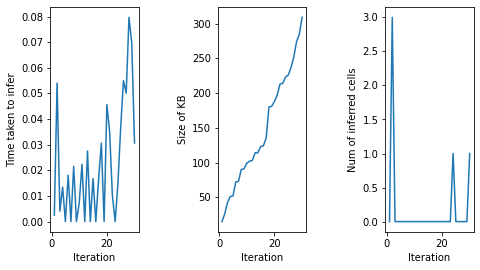

In [ ]:
y1 = [np.mean(a['inference_times']) for a in ras.move_and_record_logs]
y2 = [len(a.constraints) for a in ras.kb_snaps]
y3 = [a['num_of_inferred_cells'] for a in ras.move_and_record_logs]

x = np.arange(1, len(y1)+1, 1)

plt.subplot(1, 3, 1)
plt.plot(x, y1)
plt.ylabel('Time taken to infer')
plt.xlabel('Iteration')

plt.subplot(1, 3, 2)
plt.plot(x, y2)
plt.ylabel('Size of KB')
plt.xlabel('Iteration')

plt.subplot(1, 3, 3)
plt.plot(x, y3)
plt.ylabel('Num of inferred cells')
plt.xlabel('Iteration')

plt.subplots_adjust(wspace=0.9, bottom=0.1, left=0.01, right=0.99)

plt.show()

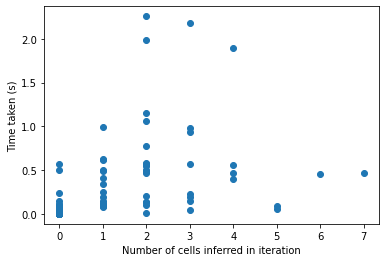

In [ ]:
plt.scatter(y3, y1)
plt.xlabel('Number of cells inferred in iteration')
plt.ylabel('Time taken (s)')
plt.show()

In [ ]:
ras.kb_snaps[2]

['c2_17=0', 'c1_8=0', 'c3_22=0', 'c1_7=1', 'c0_10=0', 'c1_19=0', 'c3_24+c3_25+c2_25+c1_25+c1_24+c1_23+c2_23+c3_23=1', 'c2_23=0', 'c1_4=0', 'c1_34=0', 'c2_10+c2_11+c1_11+c0_11+c0_10+c0_9+c1_9+c2_9=1', 'c1_16=0', 'c1_18=1', 'c0_1=0', 'c0_13=0', 'c1_30=0', 'c2_35=0', 'c1_2=0', 'c0_12=0', 'c0_14=0', 'c1_9=0', 'c0_16=0', 'c3_19+c3_20+c2_20+c1_20+c1_19+c1_18+c2_18+c3_18=1', 'c1_12=0', 'c3_33=0', 'c2_15=0', 'c2_30=0', 'c1_17=0', 'c3_28=0', 'c3_37=0', 'c2_17+c2_18+c1_18+c0_18+c0_17+c0_16+c1_16+c2_16=2', 'c2_14=0', 'c2_16=0', 'c1_3=0', 'c2_21=0', 'c1_21=0', 'c2_27=0', 'c1_22=0', 'c3_40=0', 'c3_35+c3_36+c2_36+c1_36+c1_35+c1_34+c2_34+c3_34=2', 'c1_6+c1_7+c0_7+c0_5+c1_5=1', 'c3_31=0', 'c2_32=0', 'c1_0=0', 'c2_39=0', 'c3_30=0', 'c1_33=0', 'c2_25=0', 'c3_26+c3_27+c2_27+c1_27+c1_26+c1_25+c2_25+c3_25=1', 'c0_15=0', 'c1_5=0', 'c0_8=0', 'c3_19=0', 'c3_23=0', 'c3_39=0', 'c1_23=0', 'c1_8+c1_9+c0_9+c0_7+c1_7=2', 'c2_24=0', 'c3_37+c3_38+c2_38+c1_38+c1_37+c1_36+c2_36+c3_36=1', 'c3_32=0', 'c3_34=0', 'c3_18+c3

In [ ]:
time_taken

0.6070582866668701

In [ ]:
t1 = time.time()

infer_for_vars(ras.sol_snaps[2], kb)

time_taken_1 = time.time() - t1

In [ ]:
time_taken_1

0.0001506805419921875